# Propagation
Ce script a pour but de contourer un groupe de personne à partir d'un détection en "propageant" la détection aux pixels avoisinant et ressemblants (i.e : dans la même composante connexe d'un groupe de personnes).

##### Importation des librairies

In [1]:
import os
import cv2
import time
import numpy as np

from random import randint
import matplotlib.pyplot as plt

##### Lecture des données

In [2]:
# Chemin vers les données
PATH_IMG = "/home/erwan/Centrale/OSY/DEEPL/Projet/QueueDetection/data/img/"
PATH_LABEL = "/home/erwan/Centrale/OSY/DEEPL/Projet/QueueDetection/data/labels/detection/darknet"

IMG_SIZE = 256 # nombre de pixels (height, width) de l'image
REDUCE_PERCENTAGE = 0.2 # taille de la bounding box que l'on souhaite garder pour être plus précis

In [3]:
def load_data(path_img, path_labels, img_size=256, reduce_perc=0.5):
    """
    Charge les données et leur labels contenus dans les répertoires 'path_img' et 'path_labels'
    - img_size : change la taille de l'image
    - reduce_perc : conserve une portion de la bounding box initiale pour être plus précis
    """
    x_data = list()
    y_data = list()
    print("Lecture des données...")
    
    for file in os.listdir(path_img):
        if not os.path.isfile(os.path.join(path_img, file)):
            continue
        img_name, ext = file.split(".")
        lab_name = str(img_name) + ".txt"
        if lab_name in os.listdir(path_labels):
            # Lecture de l'image
            img_path = os.path.join(path_img, file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            height, width = img.shape[0], img.shape[1]
            img = cv2.resize(img, (img_size, img_size)).astype(np.float32)
            # Lecture du label
            bounding_boxes = list()
            with open(os.path.join(path_labels, lab_name), 'r') as file_label:
                for bbox in file_label.readlines():
                    # resize coords
                    coords = list(map(lambda el : int(el), bbox.split(",")))
                    for i in range(len(coords)):
                        if i == 0 or i == 2:
                            coords[i] = int(coords[i] * img_size / width)
                        else:
                            coords[i] = int(coords[i] * img_size / height)
                    # reduce bboxes
                    gap_height = (coords[3] - coords[1]) * (1 - reduce_perc) / 2
                    gap_width = (coords[2] - coords[0]) * (1 - reduce_perc) / 2
                    coords[0] += gap_width
                    coords[1] += gap_height
                    coords[2] -= gap_width
                    coords[3] -= gap_height
                    
                    bounding_boxes.append(coords)
            # Ajout de la donnée
            x_data.append(img)
            y_data.append(bounding_boxes)
    
    x_data = np.array(x_data, dtype=np.float32)
            
    print("Nombre de données : {}".format(len(x_data)))
    return x_data, y_data

In [4]:
t1 = time.time()
x_data, y_data = load_data(PATH_IMG, PATH_LABEL, img_size=IMG_SIZE, reduce_perc=REDUCE_PERCENTAGE)
t2 = time.time()
print("Durée pour lire les données : {}s".format(round(t2-t1, 3)))

Lecture des données...
Nombre de données : 21
Durée pour lire les données : 4.841s


In [5]:
def display_random(x_data, y_data):
    """
    Affiche aléatoirement une image et les bounding boxes correspondantes
    Le paramètre 'reduce_perc' permet de réduire la fenêtre de la bounding box afin d'être plus précis
    """
    i = randint(0, len(x_data)-1)
    img = x_data[i]
    bounding_boxes = y_data[i]
    
    plt.figure(figsize=(10, 10))
    # Plot img
    plt.imshow(img.astype(np.uint8), interpolation='nearest')
    plt.axis('off')
    # Plot bboxes
    for bbox in bounding_boxes:
        left = {'x': [bbox[0], bbox[0]], 'y': [bbox[1], bbox[3]]}
        up = {'x': [bbox[0], bbox[2]], 'y': [bbox[3], bbox[3]]}
        right = {'x': [bbox[2], bbox[2]], 'y': [bbox[1], bbox[3]]}
        down = {'x': [bbox[0], bbox[2]], 'y': [bbox[1], bbox[1]]}
        plt.plot(left['x'], left['y'], c='b')
        plt.plot(up['x'], up['y'], c='b')
        plt.plot(right['x'], right['y'], c='b')
        plt.plot(down['x'], down['y'], c='b')
    
    plt.show()
    return img

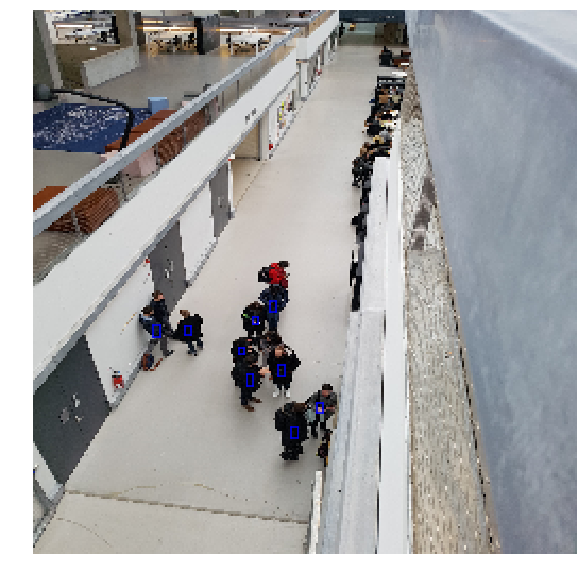

In [6]:
x = display_random(x_data, y_data)

###### Détection de foule (avec inRange)


In [7]:
def get_mask_crowd(img):
    # Find all the crowd in the image by looking for pixels in range
    lower = np.array([0, 0, 0])
    upper = np.array([40, 40, 40])
    crowdMask = cv2.inRange(img, lower, upper)
    return crowdMask

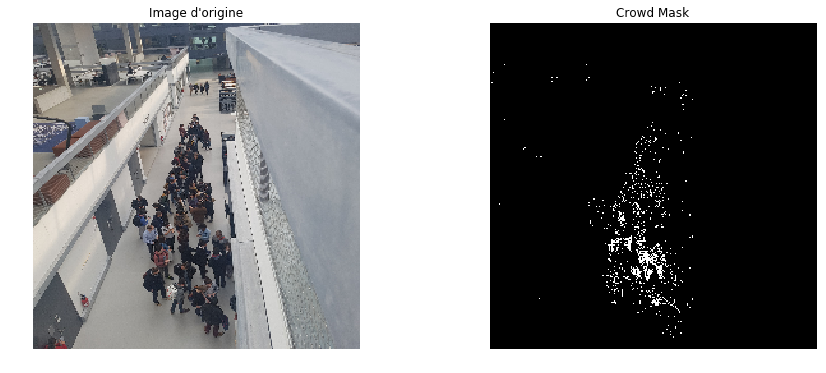

In [8]:
test_img = x_data[randint(0, len(x_data)-1)]
crowd_mask = get_mask_crowd(test_img)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_img.astype(np.uint8), interpolation='nearest')
plt.title('Image d\'origine')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(crowd_mask.astype(np.uint8), interpolation='nearest', cmap='gray')
plt.title('Crowd Mask')
plt.axis('off')
plt.show()

##### Détection de foule (avec Region Growing)

In [9]:
def region_growing(img, seed):
    # Run the region_growing post-processing on an image with a seed
    to_do = []
    outimg = np.zeros_like(img)
    to_do.append((seed[0], seed[1]))
    processed = []
    print ('Starting region_growing post-processing ...')
    while(len(to_do) > 0):
        pix = to_do[0]
        outimg[pix[0], pix[1]] = 255
        for coord in get8n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] == 0:
                outimg[coord[0], coord[1]] = 255
                if not coord in processed:
                    to_do.append(coord)
            processed.append(coord)
        to_do.pop(0)
    print ('region_growing post-processing successfully applied')
    return outimg

In [10]:
def get8n(x, y, shape):
    out = []
    maxx = shape[1]-1
    maxy = shape[0]-1

    #top left
    outx = min(max(x-1,0),maxx)
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))

    #top center
    outx = x
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))

    #top right
    outx = min(max(x+1,0),maxx)
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))

    #left
    outx = min(max(x-1,0),maxx)
    outy = y
    out.append((outx,outy))

    #right
    outx = min(max(x+1,0),maxx)
    outy = y
    out.append((outx,outy))

    #bottom left
    outx = min(max(x-1,0),maxx)
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))

    #bottom center
    outx = x
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))

    #bottom right
    outx = min(max(x+1,0),maxx)
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))

    return out

Starting region_growing post-processing ...
region_growing post-processing successfully applied


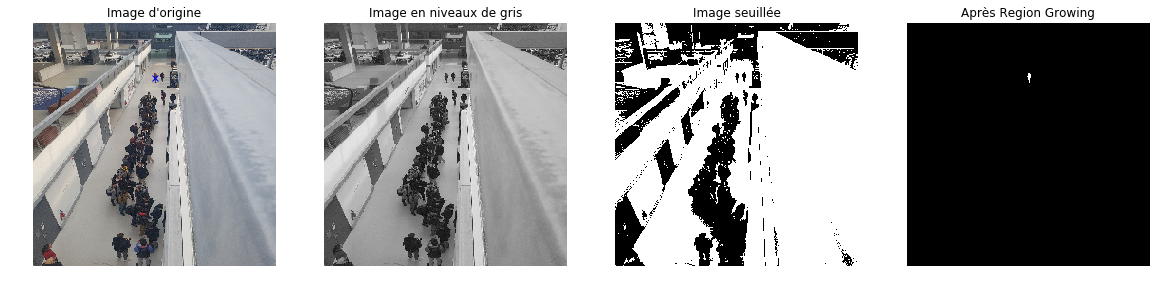

In [11]:
# Chose a random data point
chosen_i = randint(0, len(x_data)-1)
# Load the chosen image in x_data
test_img = x_data[chosen_i]
# Convert it to gray scale
gray_img = cv2.cvtColor(test_img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
# Load the related label
test_label = y_data[chosen_i]
# Get the threshold image
ret, threshold_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)
# Get the seed from the labels (single-seed algorithm for now)
seed = [int((test_label[0][1] + test_label[0][3]) / 2), int((test_label[0][0] + test_label[0][2]) / 2)]
# Run the region_growing algorithm on our threshold image with the seed
region_grown_img = region_growing(threshold_img, seed)

# Display our results
plt.figure(figsize=(20, 20))
plt.subplot(1, 4, 1)
plt.imshow(test_img.astype(np.uint8), interpolation='nearest')
plt.plot(seed[1], seed[0], c='b', marker='x')
plt.title('Image d\'origine')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(gray_img.astype(np.uint8), interpolation='nearest', cmap='gray')
plt.title('Image en niveaux de gris')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(threshold_img.astype(np.uint8), interpolation='nearest', cmap='gray')
plt.title('Image seuillée')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(region_grown_img.astype(np.uint8), interpolation='nearest', cmap='gray')
plt.title('Après Region Growing')
plt.axis('off')
plt.show()

In [12]:
def region_growing_multiple_seeds(img, seeds):
    # Run the region_growing post-processing on an image with multiple seeds
    to_do = seeds
    outimg = np.zeros_like(img)
    processed = []
    print ('Starting region_growing post-processing with multiple_seeds...')
    print('Number of seeds : {}'.format(len(seeds)))
    while(len(to_do) > 0):
        pix = to_do[0]
        outimg[pix[0], pix[1]] = 255
        processed.append(pix)
        for coord in get8n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] == 0:
                outimg[coord[0], coord[1]] = 255
                if not coord in processed:
                    to_do.append(coord)
            processed.append(coord)
        to_do.pop(0)
    print ('region_growing_multiple_seeds post-processing successfully applied')
    return outimg

In [13]:
def get_seeds(bouding_boxes):
    # Create the seeds from the bouding_boxes by computing the gravity center
    seeds = []
    for bbox in bouding_boxes:
        x0, y0, x1, y1 = bbox[0], bbox[1], bbox[2], bbox[3]
        avg_x = int((x0 + x1) / 2)
        avg_y = int((y0 + y1) / 2)
        seeds.append((avg_y, avg_x))
    return seeds

In [ ]:
# Get the seeds from the test_label
seeds = get_seeds(test_label)
# Run the region_growing algorithm with multiple_seeds on our threshold image with the seeds
region_grown_img = region_growing_multiple_seeds(threshold_img, seeds)

# Display our results
plt.figure(figsize=(20, 20))
plt.subplot(1, 4, 1)
plt.imshow(test_img.astype(np.uint8), interpolation='nearest')
plt.plot(seed[1], seed[0], c='b', marker='x')
plt.title('Image d\'origine')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(gray_img.astype(np.uint8), interpolation='nearest', cmap='gray')
plt.title('Image en niveaux de gris')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(threshold_img.astype(np.uint8), interpolation='nearest', cmap='gray')
plt.title('Image seuillée')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(region_grown_img.astype(np.uint8), interpolation='nearest', cmap='gray')
plt.title('Après Region Growing')
plt.axis('off')
plt.show()

Starting region_growing post-processing with multiple_seeds...
Number of seeds : 10
